# Airbnb Rio de Janeiro - Análise exploratória

# 1. Introdução

Este estudo tem como objetivo realizar uma Análise Exploratória de Dados (EDA) do [anúncio de imóveis do Airbnb na cidade do Rio de Janeiro](https://insideairbnb.com/get-the-data/#:~:text=Rio%20de%20Janeiro%2C%20Rio%20de%20Janeiro%2C%20Brazil). Os dados correspondem à data de 27 de Junho de 2024, correspondente à coleta de dados mais recente disponível no momento da elaboração deste estudo. 

Através desta análise, buscamos identificar variáveis que influenciam os preços, tendências e insights que possam ser úteis para ambos anfitriões e hóspedes.

## 1.1 Configurações e bibliotecas

In [1]:
import pandas as pd
from summarytools import dfSummary
from sklearn.impute import KNNImputer
from sklearn.ensemble import IsolationForest
from dython import nominal
import numpy as np
from distfit import distfit
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.patches import Patch
import ast

## 1.2 Dados utilizados

Dos dados disponíveis no site, utilizaremos apenas *[listings.csv.gz](https://data.insideairbnb.com/brazil/rj/rio-de-janeiro/2024-06-27/data/listings.csv.gz)*. Esse arquivo contém informações detalhadas dos imóveis na cidade e período considerados.

In [2]:
df_inicial = pd.read_parquet('../data/bronze/listings_train.parquet')

## 1.3 Dicionário de dados

O dicionário de dados oficial em inglês pode ser encontrado nessa [planilha Google Sheets](https://docs.google.com/spreadsheets/d/1iWCNJcSutYqpULSQHlNyGInUvHg2BoUGoNRIGa6Szc4/edit?pli=1&gid=1322284596#gid=1322284596).

| Campo                                       | Tipo     | Descrição                                                                                          |
|---------------------------------------------|----------|----------------------------------------------------------------------------------------------------|
| accommodates                                | integer  | Número máximo de hóspedes                                                                          |
| amenities                                   | text     | Lista de amenidades oferecida                                                                      |
| availability_30                             | integer  | Número de dias disponíveis nos próximos 30 dias                                                    |
| availability_365                            | integer  | Número de dias disponíveis nos próximos 365 dias                                                   |
| availability_60                             | integer  | Número de dias disponíveis nos próximos 60 dias                                                    |
| availability_90                             | integer  | Número de dias disponíveis nos próximos 90 dias                                                    |
| bathrooms                                   | float    | Número de banheiros                                                                                |
| bathrooms_text                              | text     | Descrição dos banheiros                                                                            |
| bedrooms                                    | integer  | Número de quartos                                                                                  |
| beds                                        | integer  | Número de camas                                                                                    |
| calendar_last_scraped                       | datetime | Data da última coleta no período                                                                   |
| calendar_updated                            | text     | Data da última atualização no período                                                              |
| calculated_host_listings_count              | integer  | Número calculado de anúncios do anfitrião                                                          |
| calculated_host_listings_count_entire_homes | integer  | Número calculado de anúncios de casas inteiras do anfitrião                                        |
| calculated_host_listings_count_private_rooms| integer  | Número calculado de anúncios de quartos privados do anfitrião                                      |
| calculated_host_listings_count_shared_rooms | integer  | Número calculado de anúncios de quartos compartilhados do anfitrião                                |
| description                                 | text     | Descrição do anúncio                                                                               |
| first_review                                | datetime | Data da primeira avaliação                                                                         |
| has_availability                            | boolean  | Indica se o lugar tem disponibilidade                                                              |
| host_about                                  | text     | Descrição sobre o anfitrião                                                                        |
| host_acceptance_rate                        | text     | Taxa de aceitação da hospedagem                                                                    |
| host_has_profile_pic                        | boolean  | Indica se o anfitrião possui foto de perfil                                                        |
| host_id                                     | integer  | Identificador único do anfitrião                                                                   |
| host_identity_verified                      | boolean  | Indica se a identidade do anfitrião foi verificada                                                 |
| host_is_superhost                           | boolean  | Indica se o anfitrião é um superhost                                                               |
| host_listings_count                         | integer  | Número de anúncios do anfitrião                                                                    |
| host_location                               | text     | Localização do anfitrião                                                                           |
| host_name                                   | text     | Nome do anfitrião                                                                                  |
| host_neighbourhood                          | text     | Bairro do anfitrião                                                                                |
| host_picture_url                            | text     | URL da imagem do anfitrião                                                                         |
| host_response_rate                          | text     | Taxa de resposta do anfitrião                                                                      |
| host_response_time                          | text     | Tempo de resposta do anfitrião                                                                     |
| host_since                                  | datetime | Data de cadastro do anfitrião                                                                      |
| host_thumbnail_url                          | text     | URL da imagem em miniatura do anfitrião                                                            |
| host_total_listings_count                   | integer  | Número total de anúncios do anfitrião                                                              |
| host_url                                    | text     | URL do perfil do anfitrião                                                                         |
| host_verifications                          | text     | Verificações do anfitrião                                                                          |
| id                                          | integer  | Identificador único do anúncio                                                                     |
| instant_bookable                            | boolean  | Indica se a anúncio pode ser reservada instantaneamente                                            |
| last_review                                 | datetime | Data da última avaliação                                                                           |
| last_scraped                                | datetime | UTC. A data e hora em que este anúncio foi raspado                                                 |
| latitude                                    | float    | Latitude da localidade                                                                             |
| license                                     | text     | Número da licença ou permissão para operar                                                         |
| listing_url                                 | text     | URL do anúncio                                                                                     |
| longitude                                   | float    | Longitude da localidade                                                                            |
| maximum_maximum_nights                      | integer  | Valor máximo do número máximo de noites nos próximos 365 dias                                      |
| maximum_minimum_nights                      | integer  | Valor máximo do número mínimo de noites nos próximos 365 dias                                      |
| maximum_nights                              | integer  | Número máximo de noites para estadia                                                               |
| maximum_nights_avg_ntm                      | float    | Média do valor máximo de noites nos próximos 365 dias                                              |
| minimum_maximum_nights                      | integer  | Valor mínimo do número máximo de noites nos próximos 365 dias                                      |
| minimum_minimum_nights                      | integer  | Valor mínimo do número mínimo de noites nos próximos 365 dias                                      |
| minimum_nights                              | integer  | Número mínimo de noites para estadia                                                               |
| minimum_nights_avg_ntm                      | float    | Média do valor mínimo de noites nos próximos 365 dias                                              |
| name                                        | text     | Nome da anúncio                                                                                    |
| neighbourhood                               | text     | Bairro com base em dados do Airbnb                                                                 |
| neighbourhood_cleansed                      | text     | Bairro com base em dados públicos                                                                  |
| neighbourhood_group_cleansed                | text     | Grupo de bairros com bas em dados públicos                                                         |
| neighbourhood_overview                      | text     | Descrição do bairro pelo anfitrião                                                                 |
| number_of_reviews                           | integer  | Número de avaliações                                                                               |
| number_of_reviews_l30d                      | integer  | Número de avaliações nos últimos 30 dias                                                           |
| number_of_reviews_ltm                       | integer  | Número de avaliações nos últimos 12 meses                                                          |
| picture_url                                 | text     | URL da imagem principal da anúncio                                                                 |
| price                                       | currency | Preço diário em moeda local.                                                                       |
| property_type                               | text     | Tipo de propriedade                                                                                |
| review_scores_accuracy                      | float    | Pontuação de precisão das avaliações                                                               |
| review_scores_checkin                       | float    | Pontuação de check-in das avaliações                                                               |
| review_scores_cleanliness                   | float    | Pontuação de limpeza das avaliações                                                                |
| review_scores_communication                 | float    | Pontuação de comunicação das avaliações                                                            |
| review_scores_location                      | float    | Pontuação de localização das avaliações                                                            |
| review_scores_rating                        | float    | Pontuação média das avaliações                                                                     |
| review_scores_value                         | float    | Pontuação de valor das avaliações                                                                  |
| reviews_per_month                           | float    | Número médio de avaliações por mês                                                                 |
| room_type                                   | text     | [Tipo de quarto](https://www.airbnb.com/help/article/5)                                            |
| scrape_id                                   | bigint   | Identificador da raspagem dos dados                                                                |
| source                                      | text     | Encotnrado por uma raspagem anterior ou por busca regional                                         |

## 1.4 Sumarização

Excluiremos algumas variáveis que não trazem valor à nossa análise. Também faremos algumas transformações preliminares.
- Datas do primeiro e último review são substituidas pelo intervalo em dias até a data da raspagem de dados. Uma variável binária extra 'was_reviewed' indica se a localidade foi avaliada anteriormente;
- Descrições são substituídas por sua contagem de caracteres;
- Expandir os modos de verificação do host para colunas diferentes;
- Substituição da lista de amenidades por sua contagem;
- Preço convertido para valores numéricos;

In [3]:
df_sumarizacao = df_inicial.copy()

# Converte datas para intervalo de dias entre datas
for date in ['last_scraped', 'first_review', 'last_review', 'host_since']:
    df_sumarizacao[date] = pd.to_datetime(df_sumarizacao[date], errors='coerce')
    if date != 'last_scraped':
        df_sumarizacao[f'days_since_{date}'] = (df_sumarizacao['last_scraped'] - df_sumarizacao[date]).dt.days
df_sumarizacao['was_reviewed'] = df_sumarizacao['first_review'].notna()
df_sumarizacao = df_sumarizacao.rename(columns={'days_since_host_since': 'days_since_host_active'})

# Substitui descrições por contagem de caracteres
for descricao in ['description', 'neighborhood_overview', 'host_about']:
    df_sumarizacao[f'{descricao}_length'] = df_sumarizacao[descricao].fillna('').apply(len)

# Remover símbolos de moeda e vírgulas, e converter para float
df_sumarizacao['price'] = df_sumarizacao['price'].replace(r'[\$,]', '', regex=True).astype(float)
df_sumarizacao.dropna(subset=['price'], inplace=True) # Exclui registros com preços inválidos

# Substitui amenities por sua contagem
df_sumarizacao['num_amenities'] = df_sumarizacao['amenities'].apply(ast.literal_eval).apply(len)

# Expande a coluna host_verifications em diferentes colunas
df_sumarizacao['host_verifications'] = df_sumarizacao['host_verifications'].apply(ast.literal_eval)
df_sumarizacao = df_sumarizacao.join(pd.get_dummies(df_sumarizacao.explode('host_verifications')['host_verifications'], 
                                                    prefix='verification').groupby(level=0).max())

# Flag que indica se o host chegou à responder algum cliente
df_sumarizacao['host_responded'] = df_sumarizacao['host_response_time'].notna()

# Substitui colunas com 't' e 'f' por 1 e 0 respectivamente
df_sumarizacao.replace({'t': 1, 'f': 0}, inplace=True)

# Converte colunas booleanas para inteiros (0 e 1)
bool_cols = df_sumarizacao.select_dtypes(include='bool').columns
df_sumarizacao[bool_cols] = df_sumarizacao[bool_cols].astype(int)

# Variáveis à serem eliminadas
to_drop = [
    'id', 'scrape_id', 'host_id', 'host_name', 'source', 'name', # Identificadores
    'picture_url', 'listing_url', 'host_url', 'host_thumbnail_url', 'host_picture_url', # Links
    'calendar_last_scraped', 'bathrooms_text', 'has_availability', # Não informativo
    'neighbourhood', # Outra variável tem informação equivalente
    'neighbourhood_group_cleansed', 'calendar_updated', 'license', # Variáveis faltantes ou com único valor
    'last_scraped', 'first_review', 'last_review', 'description', 'host_since', # Variáveis transformadas
    'host_about', 'amenities', 'neighborhood_overview', 'host_verifications', # Variáveis transformadas
]
df_sumarizacao.drop(columns=to_drop, inplace=True)

# Ordena as colunas alfabeticamente
df_sumarizacao = df_sumarizacao[sorted(df_sumarizacao.columns)]
dfSummary(df_sumarizacao)

No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,accommodates[int64],Mean (sd) : 4.0 (2.3)min < med < max:1.0 < 4.0 < 16.0IQR (CV) : 3.0 (1.7),16 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjkuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/TGe4hAAAACXBIWXMAAA9hAAAPYQGoP6dpAAACz0lEQVR4nO3dvY7aQBRA4TuwEPNnC4igo0nHSim25AFS7sPuIwSJIiWhTUWDkBAywTFiMKRI0q0A2xDPRefrB1wc767nasfmdDoJ4LpS0RcAXOOp6As4xxhTE5FqxuX70+kU3/J6UBxnQzXG1Lrd7qvv++0s6zebzdoY80asj8HZUEWk6vt+ezQaxUEQ7NIsDMPQm0wm7dVqVRURQn0ALocqIiJBEOx6vd6vDEtrN78YFIaHKahAqFCBUKECoUIFQoUKhAoVCBUqECpUuLjhz7wdLjgbKvN2uOLST1Tm7XDCVbN+5u0oGg9TUIFQoQKhQgVChQqEChUIFSoQKlQgVKhAqFCBUKECoUIFQoUKhAoVCBUqECpUIFSoQKhQgVChAqFCBUKFCoQKFQgVKhAqVCBUqECoUIFQoQKhQgVChQqEChUIFSrc9RWTSZJURMQ3xmRZ7h+Px8qNLwlK3S3UKIoq1trPg8GgXC6XUx0CLCJirfWSJHne7XZfRST12aw5bxIRjnV3yt1C3e/3T57n1V9eXnb9fn+ddv18Pm/PZrP64XAop12b9yYR4Vh319z97dKNRiPTadXr9TrzadV5bxKOdXeP869BzyPrTfIXx7o7hKd+qECoUIFQoQKhQgVChQqEChUIFSo89D5qHjlHsIxfb4xQ35F3BMv49fYI9R15RrCMX++DUM/IMYJl/HpjPExBBUKFCvzqd4wxpiYi1Rwf8ZA7DoTqEGNMrdvtvvq+3876GUXuOOS8yc7eYIR6Bzn2YP1ms9kbjUabIAhSb4uFYeiNx+PearX6aIzZpF0vf/4UPGZYJyLidTqdL0EQNLIsvnSDXRVqGIZe2i/ebreeiEgURd5yuaz/z/VFfvdisWhl3YP9939i1tpvIpI61DiOM+//JklSiaLoU7PZ/FEqlWza77bWeiLyPBwOv7darZ9p1sZx/GE6nZ7d0vsN7NE8cP+IF6cAAAAASUVORK5CYII="">",0(0.0%)
2,availability_30[int64],Mean (sd) : 20.2 (10.9)min < med < max:0.0 < 26.0 < 30.0IQR (CV) : 18.0 (1.9),31 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjkuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/TGe4hAAAACXBIWXMAAA9hAAAPYQGoP6dpAAACw0lEQVR4nO3dsU7bUBiG4f8kJHIIOkchadhYOiJ1iMSSC+jIxXIJIGXozNClExuSFdnCYMXY6dJKSFUgtgnpF73PGv22xXkTx5whbr1eG/C/6+z7AoBtHO37AnA4nHMDM+s3HF+t1+vnTS8SKj6Ec24wHo+vvPejJvNpmi6dc9ebYiVUfJS+9340n8+fQwh5ncEkSaLFYjGK47hvZoSK3Qsh5NPp9KnB6OCtF3mYggRChQRChQRChQRChQRChQRChQRChQRChQRChQRChQRChQRChQRChQRChQRChQRChQRChQRChQRChQRChQRChQRChQRChQRChQRChQRChQRChQRChQRChQRChQRChQRChQRChQRChQRChQRChQRChQRChQRChQRChQRChQRChQRChQRChYR3f13aOTcws37D4682/f46UMeboTrnBuPx+Mp7P2py8DRNl865a2JFW+99ova996P5fP4cQsjrHDhJkmixWIziOO6bGaGilXdv/WZmIYR8Op0+NTj+oMEM8A8epiCBUCGBUCGBUCGBUCFhq6d+6DjUDRpCPSCHvEFDqIel1QbN7e3tNI7jiXMubXBuX1VVr8HcVgh1g5a30I6ZVXuY9VVV9UIIy7obNFmW9Yqi+HZ+ft7tdru1IjczK4oiKsvyIs/zGzNrsjn0pp2GWpZlz8y8c67pIfa14NHp6en3EMKw7mBZlr0sy76enJz86nQ6xWfNmrWLZbVaHUVRdDybzfKzs7Nl3XPf39+P7u7ujl9eXrp1Z7exs1DbvkP3veBmdnF5efljMpnUug3+WbAvs9nsZ90FbzP7ar5VLMPhsNF2+XK53Ol2+c5C/aB36F4XPIqiou6i/V2wJgveZvb1/CHa+XfUtn90Fhxm/MMfIrb6RE2SJKp74MfHx8jMLMuy6OHh4fgz51XPrXrdbee36es3UPtpn0q2/aoAAAAASUVORK5CYII="">",0(0.0%)
3,availability_365[int64],Mean (sd) : 205.7 (114.6)min < med < max:0.0 < 193.0 < 365.0IQR (CV) : 232.0 (1.8),366 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjkuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/TGe4hAAAACXBIWXMAAA9hAAAPYQGoP6dpAAACg0lEQVR4nO3bTYriQBiH8bfGVqJCgjTozgsMzMKlh5jDzhFm4Qm8gTtBJGKmg/Fj1gN+JtZU/cPz20p11+LBvIkVd7lcDIjdt9AbAJ7xEXoDaA/nXN/MejWXHy6Xy9etDwkVb+Gc639+fv5M03RUZ/1ut9s6537dipVQ8S69NE1H8/n8K8uy8pWFeZ4ni8VitNlsemZGqPAvy7JyPB7/qbG0f+9DbqYggVAhgVAhgVAhgVAhgVAhgVAhgVAhgVAhgVAhgVAhgVAhgVAhgVAhgVAhgVAhgVAhgVAhgVAhIep3pny+fgst0Ybq+/VbaIk2VPP8+i20xByqmfl7/RZauJmCBEKFBEKFhOhn1FB4NBYXQr2CR2PxIdTreDQWGUK9Q/HRWFtHFkJtkTaPLITaLq0dWQi1hRRHlkd4jgoJhAoJhAoJhAoJhAoJhAoJhAoJhAoJhAoJhAoJXn9CbXiSJz2fz9137ge6vIXa9CRPVVXJ6XT6XpblbzOr87s1WsTnN2rtkzxmZqvVarRcLgfH47HjY3PQ8jDUBpfv9Hw+d7Ms29Y5ybPdbhud5DmdTl0zS51zdZYHGzsYl667G2qTy3fIS3dRFN2qqn5Mp9NOp9N5+ds81N4Zl2579I1a+/Id8tJ9OBw+kiQZzGazcjKZbF9dH3DvjEs3PDWj1jmI2/TS/Q7D4bDWAeLQe6978Dn0vn3ihL8HDebj1s6YTRHqmzWZj0PPmDHfgBLqmzWZj0POmLHfgBKqJ3Xm45AzZuw3oISKf8R6A8qhFEggVEggVEggVEggVEggVEggVEggVEh46oF/nufJq394v98nZmZFUSTr9XrwP9er/m/VfTdd/0xffwHXXKj5cWeWVAAAAABJRU5ErkJggg=="">",0(0.0%)
4,availability_60[int64],Mean (sd) : 43.9 (19.8)min < med < max:0.0 < 

# 2. Análise da variável resposta

Dentre as distribuições populares testadas, a que melhor se ajusta ao preço é a distribuição lognormal.

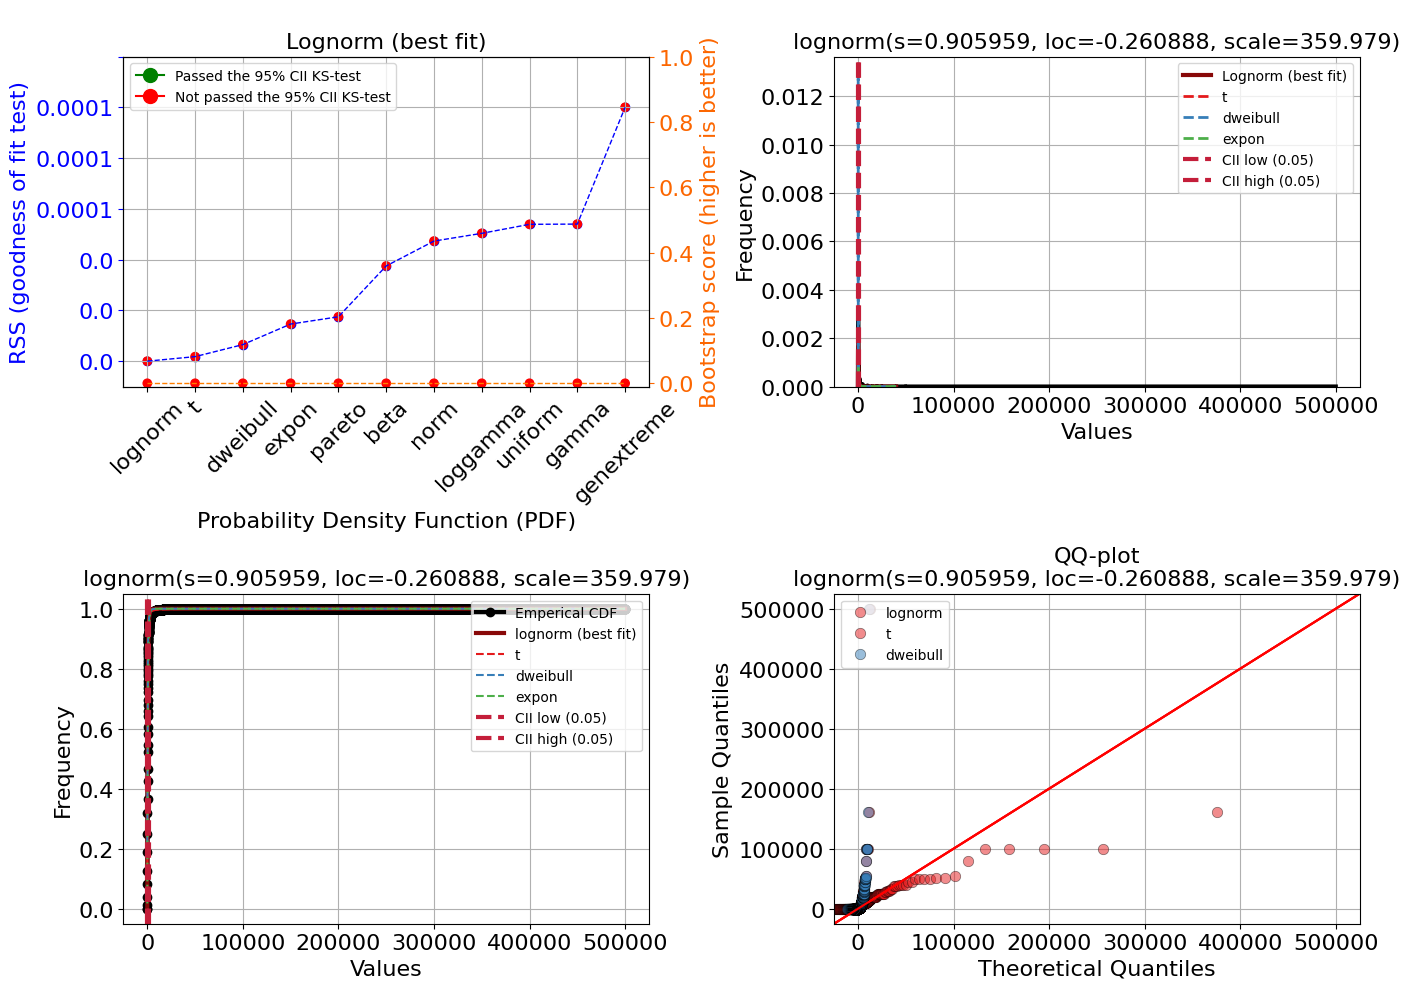

In [4]:
dfit = distfit(alpha=.05, distr='popular', random_state = 75, verbose = False)
dfit.fit_transform(df_sumarizacao['price'], verbose = False)
dfit.bootstrap(
    X = df_sumarizacao['price'], 
    n_boots=100, 
    alpha=0.05,
    n=10_000,
    n_top=3, 
    update_model=True
)
fig, axs = plt.subplots(2, 2, figsize=(14, 10))
dfit.plot_summary(ax=axs[0, 0])
dfit.plot(chart='pdf', n_top=3, ax=axs[0, 1])
dfit.plot(chart='cdf', n_top=3, ax=axs[1, 0])
dfit.qqplot(df_sumarizacao['price'], n_top=3, ax=axs[1, 1])
plt.tight_layout()

## 3. Correlação entre as variáveis

Esse dataset contém variáveis de diversos tipos. Usaremos a matriz de correlação proposta pela biblioteca [_dython_](https://shakedzy.xyz/dython/modules/nominal/).
Ela utiliza diferentes estratégias para mensurar a associação entre as variáveis dependendo dos tipos envolvidos:

- Caso contínuo-contínuo: [Correlação R de Pearson](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient);
- Caso categórico-contínuo: [Coeficiente de correlação](https://en.wikipedia.org/wiki/Correlation_ratio);
- Caso categórico-categórico: [V de Cramér](https://www.statstest.com/cramers-v-2/).

Não observamos nenhuma correlação linear entre as variáveis explicativas e a variável resposta.
Porém, podemos eliminar variáveis explicativas que tenham alta correlação entre si.

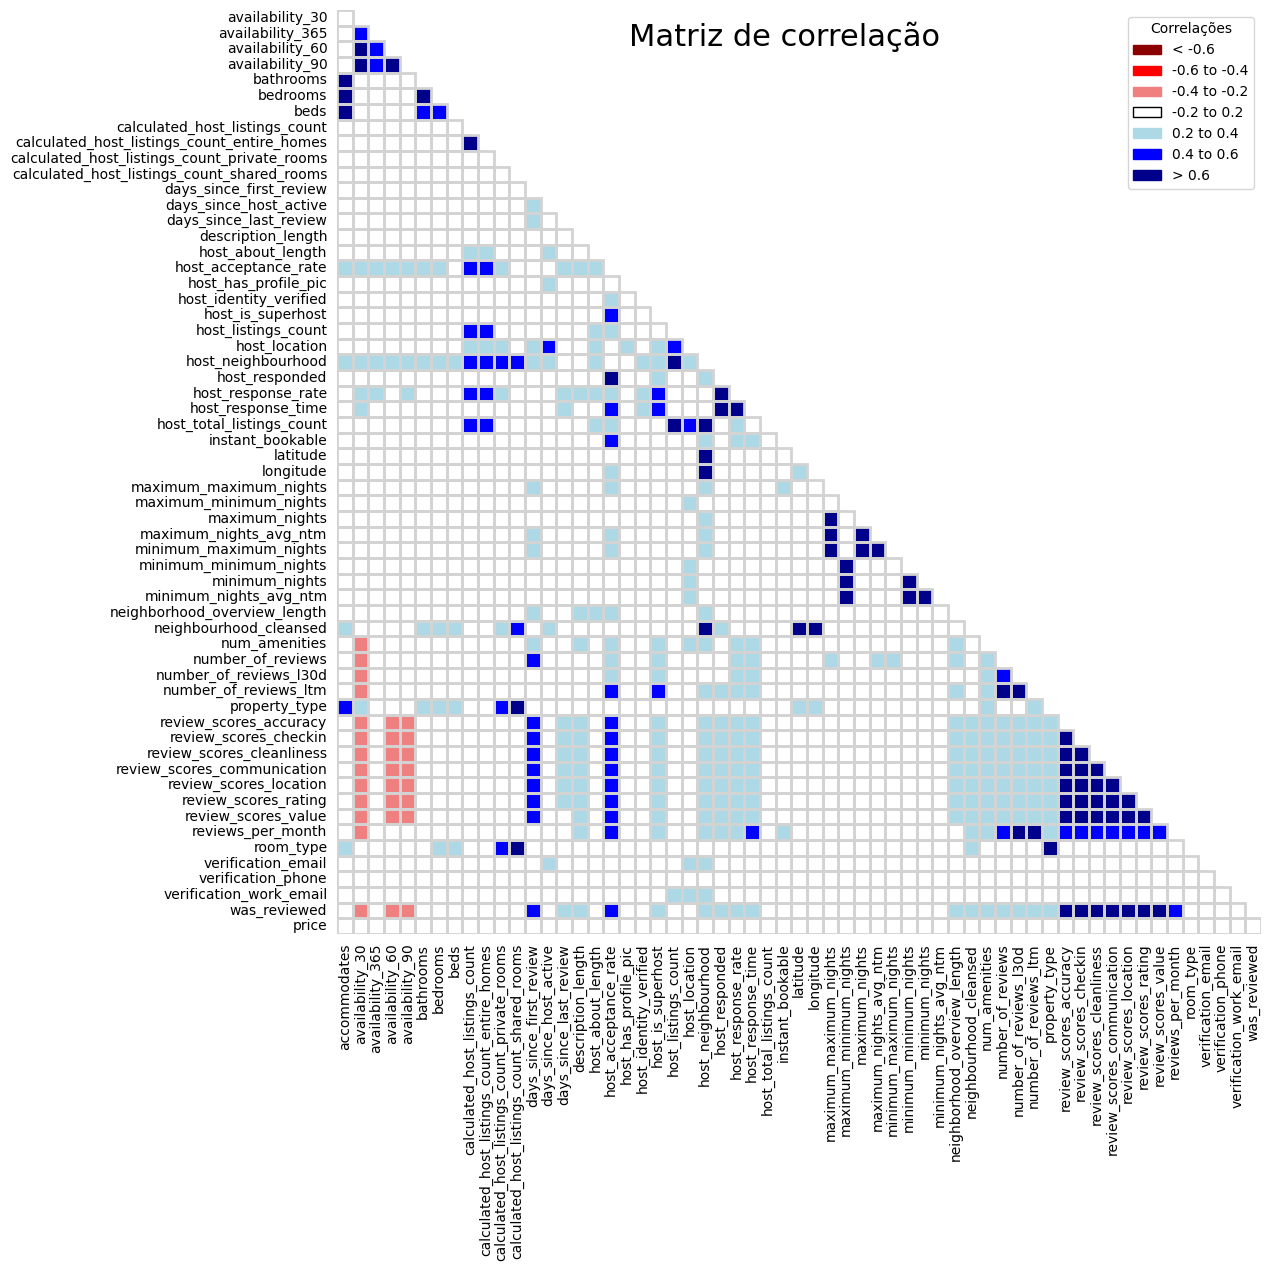

In [28]:
def matriz_correlacao(features):
    # Cálculo das correlações e obtenção do valor absoluto das correlações
    corr = nominal.associations(dataset=df_sumarizacao[features], plot=False, compute_only=True)['corr']

    # Máscara para o triângulo superior
    mask = np.triu(np.ones_like(corr, dtype=bool))

    # Remove primeira linha e última coluna, seriam vazias
    corr = corr.iloc[1:, :-1]
    mask = mask[1:, :-1]

    # Definir cores personalizadas
    cmap = ListedColormap(['darkred', 'red', 'lightcoral', 'white', 'lightblue', 'blue', 'darkblue'])
    bounds = [-1, -0.6, -0.4, -0.2, 0.2, 0.4, 0.6, 1]
    norm = BoundaryNorm(bounds, cmap.N)

    # Instancia o gráfico
    fig, ax = plt.subplots(figsize=(12, 12))

    # Desenha o heatmap sem linhas
    sns.heatmap(data=corr, mask=mask, cmap=cmap, norm=norm, cbar=False, square=True, 
                linewidths=0, annot=False, ax=ax)

    # Desenha as linhas de grade manualmente
    for i in range(corr.shape[0]):
        for j in range(corr.shape[1]):
            if not mask[i, j]:
                ax.add_patch(plt.Rectangle((j, i), 1, 1, fill=False, edgecolor='lightgrey', lw=2))

    # Rotacionar labels do eixo X em 90 graus
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    ax.tick_params(left=False, bottom=False)

    # Adicionar legenda personalizada
    legend_elements = [
        Patch(facecolor='darkred', edgecolor='darkred', label='< -0.6'),
        Patch(facecolor='red', edgecolor='red', label='-0.6 to -0.4'),
        Patch(facecolor='lightcoral', edgecolor='lightcoral', label='-0.4 to -0.2'),
        Patch(facecolor='white', edgecolor='black', label='-0.2 to 0.2'),
        Patch(facecolor='lightblue', edgecolor='lightblue', label='0.2 to 0.4'),
        Patch(facecolor='blue', edgecolor='blue', label='0.4 to 0.6'),
        Patch(facecolor='darkblue', edgecolor='darkblue', label='> 0.6')
    ]
    ax.legend(handles=legend_elements, loc='upper right', title='Correlações')

    fig.text(x=.5, y=.87, s="Matriz de correlação", ha="center", va="top", size=22)  # Título

# Chamar a função com as colunas ordenadas exceto "price"
matriz_correlacao(sorted(c for c in df_sumarizacao.columns if c != 'price') + ['price'])

# Eliminando variáveis altamente correlacionadas entre si
to_drop = ['availability_30', 'availability_60', 'availability_90', 'accommodates', 'bathrooms',
           'calculated_host_listings_count_entire_homes', 'host_listings_count', 'host_responded',
           'host_response_rate', 'latitude', 'longitude', 'host_neighbourhood', 'maximum_maximum_nights',
           'maximum_minimum_nights', 'maximum_nights', 'minimum_maximum_nights', 'minimum_minimum_nights',
           'minimum_nights', 'number_of_reviews_l30d', 'number_of_reviews_ltm', 'calculated_host_listings_count_shared_rooms',
           'review_scores_accuracy', 'review_scores_checkin', 'review_scores_cleanliness', 'review_scores_communication',
           'review_scores_location', 'review_scores_value', 'was_reviewed', 'property_type', 'host_location']
df_correlacao = df_sumarizacao.drop(columns=to_drop)
df_correlacao.to_parquet('../data/bronze/feature_engineering_input.parquet')

# 4. Análise multivariada

Com a finalidade de facilitar a leitura dos gráficos, consideremos os preços sem outliers.

In [6]:
df_multivariada = df_correlacao.copy()
print(f'Registros antes da filtragem: {df_multivariada.shape[0]}')

# Treinar o modelo Isolation Forest
iso_forest = IsolationForest(contamination=0.01)
df_multivariada['anomaly'] = iso_forest.fit_predict(df_multivariada[['price']])

# Filtrar os registros que não são outliers
df_multivariada = df_multivariada[df_multivariada['anomaly'] == 1]
print(f'Registros depois da filtragem: {df_multivariada.shape[0]}')

# Remover a coluna de anomalias
df_multivariada.drop(columns='anomaly', inplace=True)

variaveis_quantitativas = ['availability_365', 'bedrooms', 'beds', 'calculated_host_listings_count', 'calculated_host_listings_count_private_rooms',
                           'days_since_first_review', 'days_since_host_active', 'days_since_last_review', 'description_length', 'host_about_length',
                           'host_acceptance_rate', 'host_total_listings_count', 'maximum_nights_avg_ntm', 'minimum_nights_avg_ntm', 'neighborhood_overview_length',
                           'num_amenities', 'number_of_reviews', 'review_scores_rating', 'reviews_per_month']

variaveis_categoricas = ['host_has_profile_pic', 'host_identity_verified', 'host_is_superhost', 'host_response_time', 'verification_work_email',
                         'instant_bookable', 'neighbourhood_cleansed', 'room_type', 'verification_email', 'verification_phone']

Registros antes da filtragem: 26958
Registros depois da filtragem: 26691


### 4.1 Preço vs variáveis quantitativas

- `number_of_reviews`: Existe uma tendência de que, quanto maior o número de avaliações, menor é o preço. Isso pode sugerir que propriedades com preços mais baixos atraem mais hóspedes e são mais avaliadas
- `reviews_per_month`: Há uma tendência de que, quanto maior o número de avaliações por mês, menor é o preço
- `review_scores_rating`: A maioria dos pontos está concentrada em notas altas (4 a 5) e essas propriedades têm uma grande variação de preços, incluindo preços altos. Propriedades com notas mais baixas tendem a serem mais baratas
- `calculated_host_listings_count_private_rooms`: A maioria das propriedades com muitos quartos privados tem preços relativamente baixos. Propriedades com poucos quartos privados (0 a 5) têm uma maior variação de preços. Pode indicar que hosts que listam muitas propriedades privadas tendem a oferecer preços mais competitivos

Parece não haver uma relação clara entre a variável resposta e as demais variáveis.

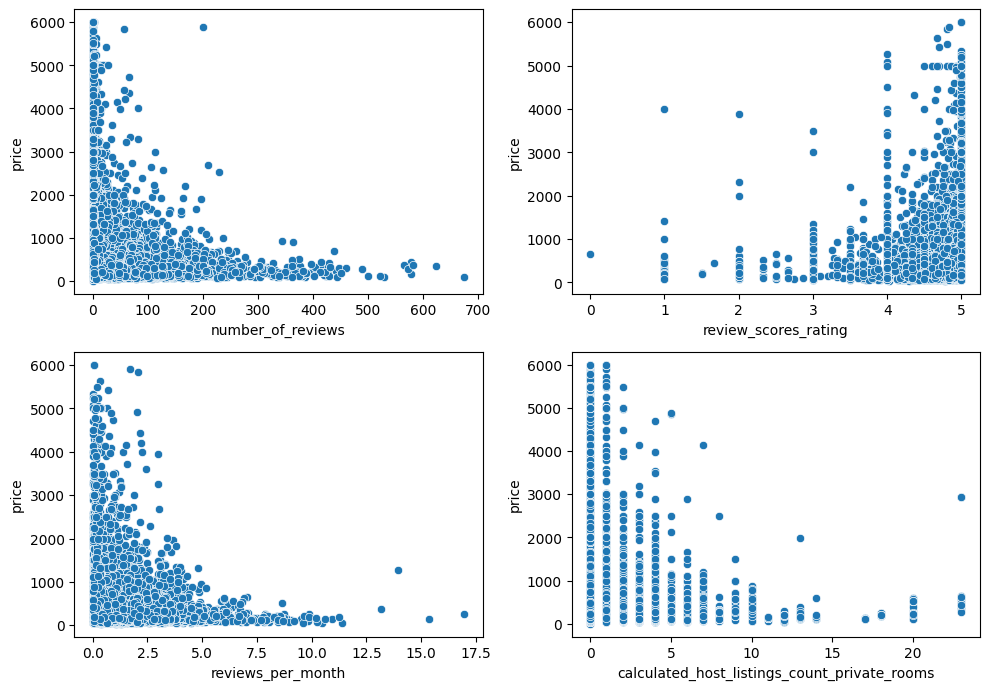

In [7]:
plt.figure(figsize=(10, 10))

quantitativas_filtradas = ['number_of_reviews', 'review_scores_rating', 'reviews_per_month', 'calculated_host_listings_count_private_rooms']

# Número de variáveis quantitativas
num_vars = len(quantitativas_filtradas)

# Loop para criar os scatterplots
for i, var in enumerate(quantitativas_filtradas):
    plt.subplot((num_vars // 2) + 1, 2, i + 1)
    sns.scatterplot(x=df_multivariada[var], y=df_multivariada['price'])
    plt.xlabel(var)

plt.tight_layout()

### 4.2 Preço vs variáveis categóricas

- `room_type`: Casas/apartamentos inteiros têm os preços médios mais altos, seguidos por quartos de hotel, quartos privados e quartos compartilhados
- `host_has_profile_pic`: A média dos preços é ligeiramente mais alta para hosts que não possuem foto de perfil
- `host_identity_verified`: Hosts com identidade não verificada tem preços médios maiores
- `host_is_superhost`: Hosts que atenderam o critério de superhost tem preços médios menores
- `instant_bookable`: Preços médios são ligeiramente mais altos para propriedades que não são reserváveis de imediato
- `verification_work_email`: Hosts com emails profissionais verificados cobram preços médios mais altos
- `verification_email`: Hosts com emails verificados cobram preços médios ligeiramente mais altos
- `verification_phone`: Hosts com telefone não verificado têm preços médios mais altos do que aqueles com telefone verificado.

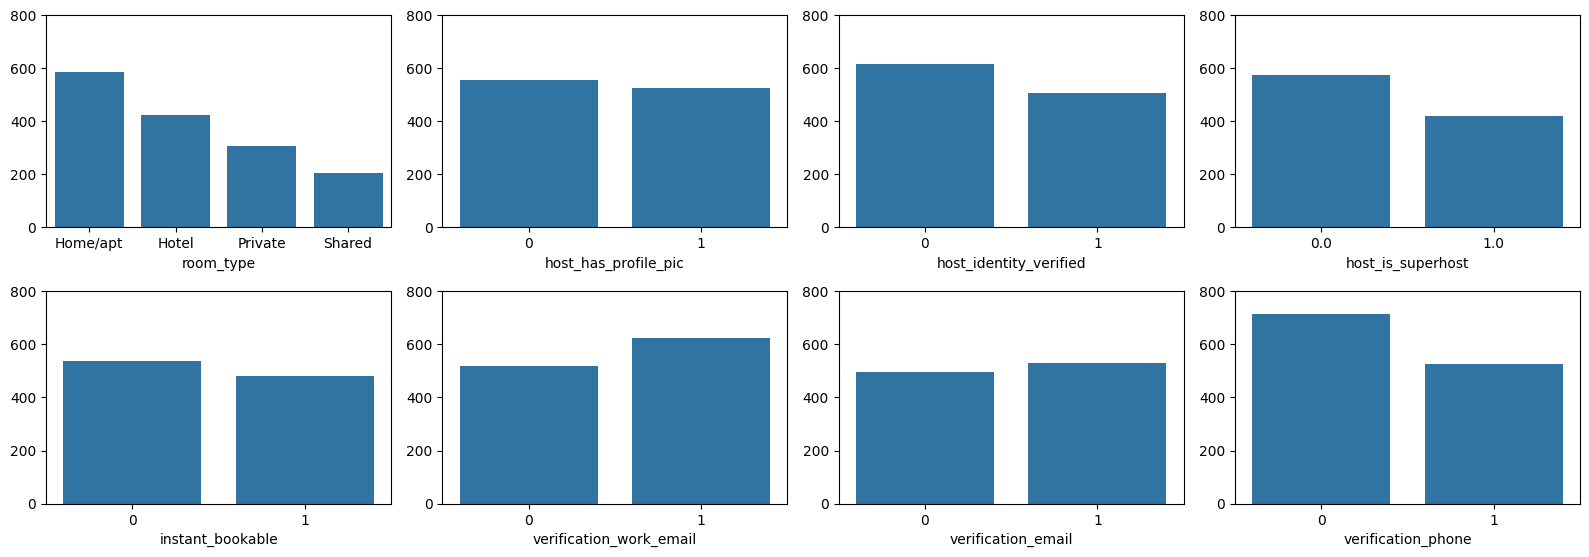

In [10]:
plt.figure(figsize=(16, 8))

# Lista de variáveis qualitativas
categoricas_filtradas = ['room_type', 'host_has_profile_pic', 'host_identity_verified', 'host_is_superhost', 
                         'instant_bookable',  'verification_work_email', 'verification_email', 'verification_phone']

# Número de variáveis qualitativas
num_vars = len(categoricas_filtradas)

# Mapeamento de valores de room_type para o gráfico
room_type_mapping = {
    'Entire home/apt': 'Home/apt',
    'Hotel room': 'Hotel',
    'Private room': 'Private',
    'Shared room': 'Shared'
}

# Loop para criar os gráficos de barra
for i, var in enumerate(categoricas_filtradas):
    plt.subplot((num_vars // 4) + 1, 4, i + 1)
    
    # Agrupar por variável qualitativa e calcular a média dos preços
    data = df_multivariada.groupby(var)['price'].mean().reset_index()
    
    # Ordenar os dados pelo preço médio
    data = data.sort_values(by='price', ascending=False)
    
    # Criar o gráfico de barra
    ax = sns.barplot(x=data[var], y=data['price'])
    plt.xlabel(var)
    plt.ylim(0, 800)
    plt.ylabel('')

    # Alterar os tick labels para 'room_type'
    if var == 'room_type':
        ax.set_xticklabels([room_type_mapping.get(label) for label in data[var]])

plt.tight_layout()

- `neighbourhood_cleansed`: Os bairros com aluguéis mais caros são Anchieta (2615), seguido de Galeão (2475) e Joá (2359). Os bairros com aluguéis mais baratos são Mangueira (52), seguido de Vila Kosmos (64) e Manguinhos (72). A média dos outros 143 bairros é 335

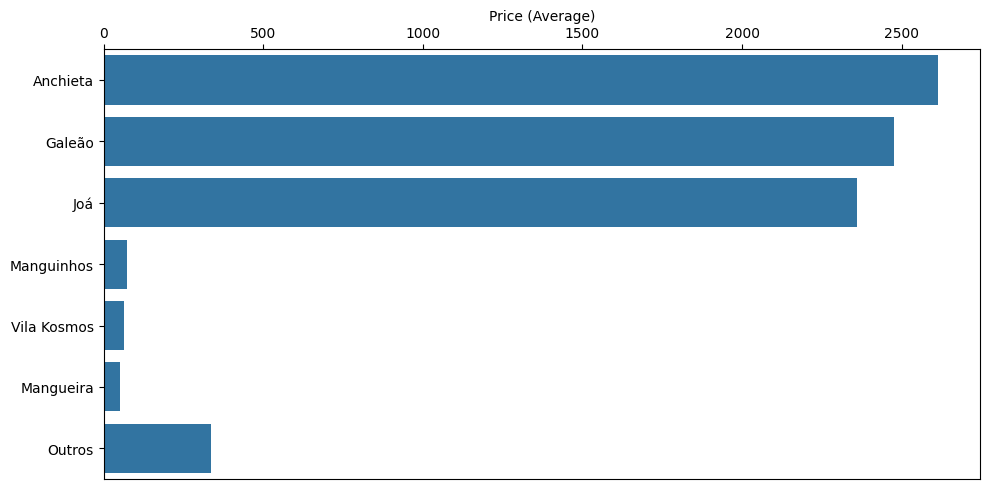

In [9]:
# Agrupar por variável qualitativa e calcular a média dos preços
data = df_multivariada.groupby('neighbourhood_cleansed')['price'].mean().reset_index()

# Ordenar os dados pelo preço médio
data = data.sort_values(by='price', ascending=False)

top3 = data.head(3) # Seleciona os três mais caros
bottom3 = data.tail(3) # Seleciona os três mais baratos

# Calcular a média de todos os outros
others_mean = data.iloc[3:-3]['price'].mean()

# Criar um DataFrame para 'others'
others = pd.DataFrame({'neighbourhood_cleansed': ['Outros'], 'price': [others_mean]})

# Combinar os DataFrames
combined_data = pd.concat([top3, bottom3, others], ignore_index=True)

# Criar o gráfico de barra horizontal
plt.figure(figsize=(10, 5))
ax = sns.barplot(x=combined_data['price'], y=combined_data['neighbourhood_cleansed'], orient='h')

# Definir o label do eixo x e y
ax.set_xlabel('Price (Average)')
ax.set_ylabel('')

# Mover o eixo x para a parte superior
ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top')
plt.tight_layout()

- `host_response_time`: O preço médio mais alto dentre as categorias acontece quando o host responde dentro de algumas horas. O preço mais baixo quando o host responde dentro de uma hora.

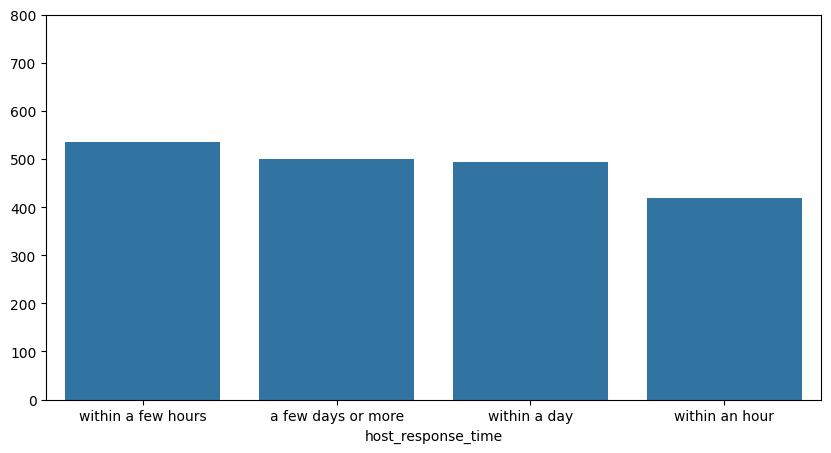

In [19]:
# Loop para criar os gráficos de barra
plt.figure(figsize=(10, 5))

# Agrupar por variável qualitativa e calcular a média dos preços
data = df_multivariada.groupby('host_response_time')['price'].mean().reset_index()

# Ordenar os dados pelo preço médio
data = data.sort_values(by='price', ascending=False)

# Criar o gráfico de barra
ax = sns.barplot(x=data['host_response_time'], y=data['price'])
plt.xlabel('host_response_time')
plt.ylim(0, 800)
plt.ylabel('');

## 5. Conclusão